# Mask R-CNN  - Inspect Fish vs All Training Data

Inspect and visualize data loading and pre-processing code.

In [1]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR) # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import fishvsall

%matplotlib inline

Using TensorFlow backend.


## Configurations

Configurations are defined in fish_vs_all.py

In [4]:
config = fishvsall.FishConfig()
#FISH_DIR = os.path.join(ROOT_DIR, "datasets/fish")
FISH_DIR = "/media/ernesto/Seagate Backup Plus Drive/Dataset_Thesis/Dia/Video_sin_reflejo"
FISH_DIR 

'/media/ernesto/Seagate Backup Plus Drive/Dataset_Thesis/Dia/Video_sin_reflejo'

## Dataset

In [5]:
# Load dataset
# Get the dataset from the releases page
# https://github.com/matterport/Mask_RCNN/releases
dataset = fishvsall.FishDataset()
dataset.load_fish(FISH_DIR, "train")

#Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}.{:50}".format(i,info['name']))

Image Count: 2127
Class Count: 2
  0.BG                                                
  1.fish                                              


## Display samples
Load and display images and masks.

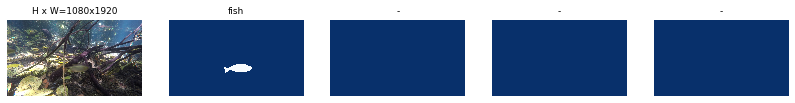

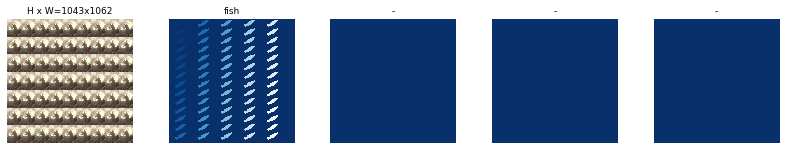

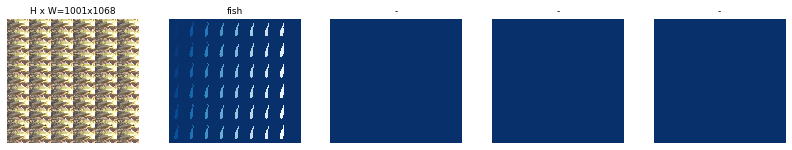

IndexError: index 1014 is out of bounds for axis 1 with size 1014

In [6]:
# Load and display random  samples
image_ids = np.random.choice(dataset.image_ids,4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Bounding boxes

Rather than using bounding box coordinates provided by the source datasets, we compute the bounding boxes from masks instead. This allows us to handle bounding boxes consistently regardless of he source dataset, and it also makes it easier to resize, rotate or crop images because we simply generate the bounding boxes from the updates masks rather than computing bounding box transformation for each type of image transformation.

In [ ]:
# Load random image and mask
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id) # Depending on the number of instances, mask has i number of channels

# Compute bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)

# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Resize Images 

To support multiple images per batch, images are resized to one size (1024x1024). Aspect ratio is preserved, though. If an image is not square, then zero padding is added at the top/bottom or right/left.

In [ ]:
#Load random image and mask 
image_id =np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
#Resize
image, windoe, scale, padding, _ =utils.resize_image(
    image,
    min_dim=config.IMAGE_MIN_DIM,
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

#Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("original shape:", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
#Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Mini Mask

Instance binary masks can get large when training with high resolution images. For example, if training with 1024x1024 image then the mask of a single instance requires 1MB of memory (Numpy uses bytes for boolean values). If an image has 100 instances then that's 100MB for the masks alone. 

To improve training speed, we optimize masks by:
* We store mask pixels that are inside the object bounding box, rather than a mask of the full image. Most objects are small compared to the image size, so we save space by not storing a lot of zeros around the object.
* We resize the mask to a smaller size (e.g. 56x56). For objects that are larger than the selected size we lose a bit of accuracy. But most object annotations are not very accuracy to begin with, so this loss is negligable for most practical purposes. Thie size of the mini_mask can be set in the config class.

To visualize the effect of mask resizing, and to verify the code correctness, we visualize some examples.

In [ ]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)
log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

In [ ]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [ ]:
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

In [ ]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Anchors

The orders of anchors is important. Use the same order in training and prediction phases. And it must match the order of the convolution execution.

For a FPN network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts.

* Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
* Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row.
* For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passes to the function.

**Anchor Stride:** 
In the FPN architecture, feature maps at the first few layers are high resolution. For example, if the input image is 1024x1024 then the feature map of the first layer is 256x256, which generates about 200K anchors (256X256X3). These anchors are 32x32 pixels and their stride relative to image pixels is 4 pixels, so there is a lot of overlap. We can reduce the load significantly if we generate anchors for every other cell in the feature map. A stride of 2 will cut the number of anchors by 4, for example. 

In this implementation we use an anchor stride of 2, which is different from the paper.

In [12]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES,
                                            config.RPN_ANCHOR_RATIOS,
                                            backbone_shapes,
                                            config.BACKBONE_STRIDES,
                                            config.RPN_ANCHOR_STRIDE)
#Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scale: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level=[]
for l in range(num_levels):
    num_cells = backbone_shapes[l][0]*backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell*num_cells// config.RPN_ANCHOR_STRIDE**2)
    print("Anchor in level {}: {}".format(l, anchors_per_level[l]))

Count:  261888
Scale:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per cell:  3
Levels:  5
Anchor in level 0: 196608
Anchor in level 1: 49152
Anchor in level 2: 12288
Anchor in level 3: 3072
Anchor in level 4: 768


In [16]:
scale=config.RPN_ANCHOR_SCALES[0]
ratio=config.RPN_ANCHOR_RATIOS
scales, ratios = np.meshgrid(np.array(scale), np.array(ratio))
print(scale, ratio)
print(scales)
print(ratios)

32 [0.5, 1, 2]
[[32]
 [32]
 [32]]
[[0.5]
 [1. ]
 [2. ]]


In [19]:
scales.flatten()
ratios.flatten()
heights = scales/np.sqrt(ratios)
widths = scales * np.sqrt(ratios)
print(scales)
print(ratios)
print(heights)
print(widths)

[[32]
 [32]
 [32]]
[[0.5]
 [1. ]
 [2. ]]
[[45.254834]
 [32.      ]
 [22.627417]]
[[22.627417]
 [32.      ]
 [45.254834]]


Visualize anchors of one cell at the center of the feature map of a specific level

Level 0. Anchors: 196608 Feature map Shape: [256 256]
Level 1. Anchors:  49152 Feature map Shape: [128 128]
Level 2. Anchors:  12288 Feature map Shape: [64 64]
Level 3. Anchors:   3072 Feature map Shape: [32 32]
Level 4. Anchors:    768 Feature map Shape: [16 16]


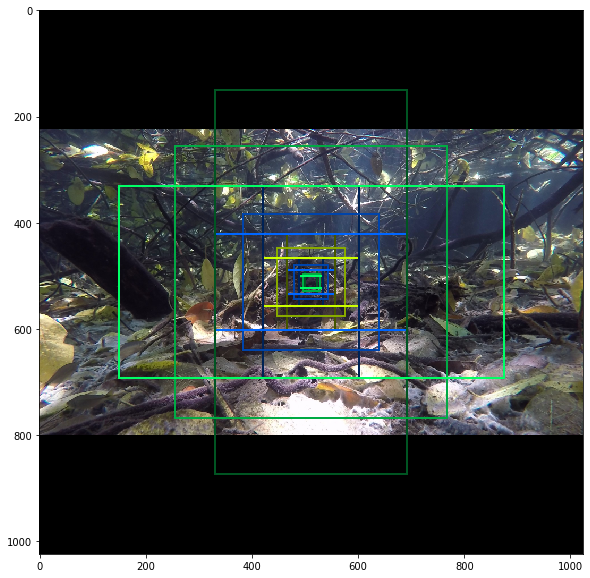

In [13]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _= modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10,10))
ax.imshow(image)
levels = len(backbone_shapes)
for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # Sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6} Feature map Shape: {}".format(level, level_anchors.shape[0],
                                                                 backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0]*backbone_shapes[level][1]+center_cell[1])
    level_center = center_cell_index * anchors_per_cell
    center_anchor = anchors_per_cell * ((center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2)\
                                       + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)
    
    #Draw anchors. Brightness show the order in the array, dark to bright.
    
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=2, facecolor = 'none',
                             edgecolor = (i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


# Data generator

In [14]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(dataset, config, shuffle = True, random_rois = random_rois, batch_size=4, detection_targets=True)

In [15]:
# Get next image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
    
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match)
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn _class_ids. It's only added
# to satisfy keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]    
    

rois                     shape: (4, 200, 4)           min:    0.00000  max: 1023.00000  int32
mrcnn_class_ids          shape: (4, 200, 1)           min:    0.00000  max:    1.00000  int32
mrcnn_bbox               shape: (4, 200, 2, 4)        min:   -3.14815  max:    3.78378  float32
mrcnn_mask               shape: (4, 200, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (4, 100)              min:    0.00000  max:    1.00000  int32
gt_boxes                 shape: (4, 100, 4)           min:    0.00000  max:  982.00000  int32
gt_masks                 shape: (4, 56, 56, 100)      min:    0.00000  max:    1.00000  bool
rpn_match                shape: (4, 261888, 1)        min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (4, 256, 4)           min:   -1.76777  max:    1.81039  float64
image_id:  176 /media/iimas-doc/Seagate Backup Plus Drive/Dataset_Thesis/Dia/Video_sin_reflejo/GOPR5025_13_30.jpg


anchors                  shape: (261888, 4)           min: -362.03867  max: 1322.03867  float64
refined_anchors          shape: (2, 4)                min:  500.00000  max:  982.00000  float32
Positive anchors: 2
Negative anchors: 254
Negative anchors: 261632
BG                     : 171
fish                   : 29


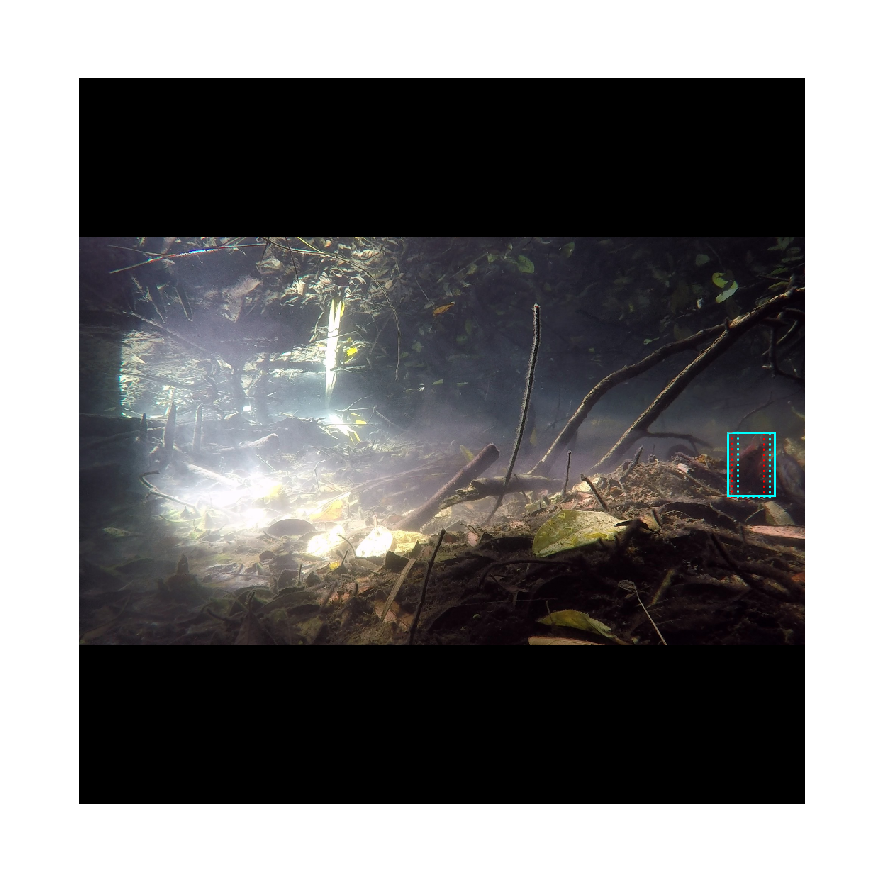

In [16]:
b = 0
# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Computer anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)]*config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of ṕositive anchors
positive_anchors_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchors_ids)))
negative_anchors_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchors_ids)))
neutral_anchors_ids = np.where(rpn_match[b] == 0)[0]
print("Negative anchors: {}".format(len(neutral_anchors_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20],n))
        
# Show positive anchors
fig, ax = plt.subplots(1, figsize = (16,16))
visualize.draw_boxes(sample_image,boxes =  anchors[positive_anchors_ids], 
                     refined_boxes = refined_anchors, 
                     ax = ax)

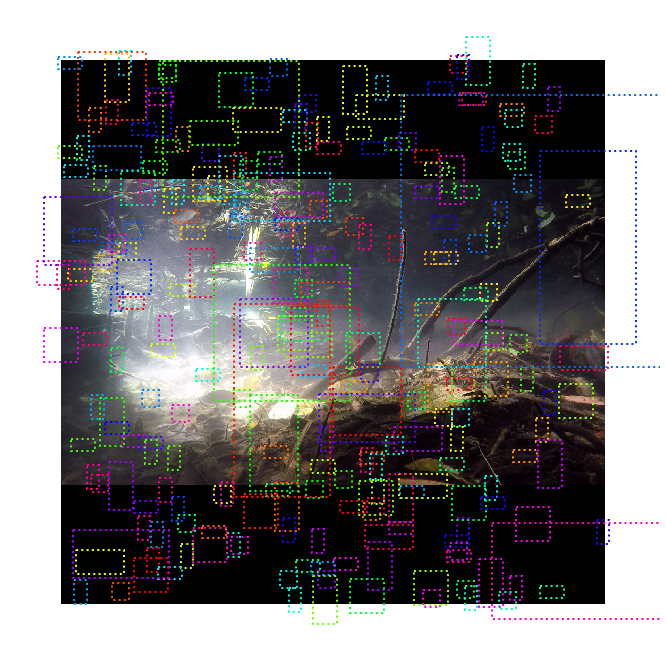

In [17]:
# Show negative anchors
visualize.draw_boxes(sample_image,boxes = anchors[negative_anchors_ids])

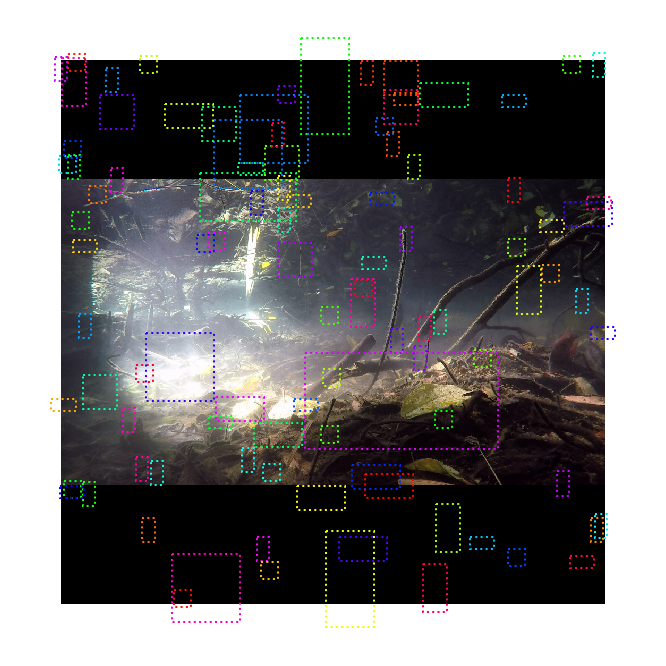

In [18]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchors_ids, 100)])

# ROIs

Positive ROIs:  29
Negative ROIs:  171
Positive Ratio: 0.14
Unique ROIs: 200 out of 200


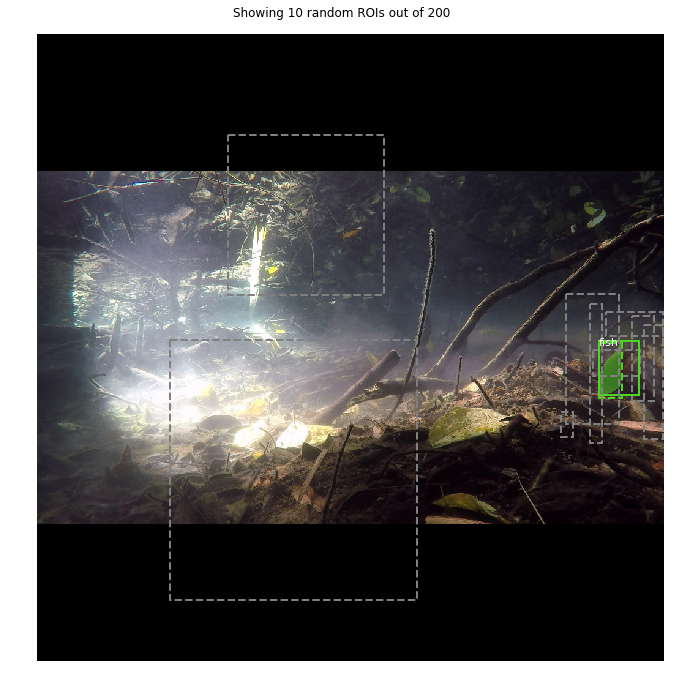

In [19]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]
    
    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4]*config.BBOX_STD_DEV)
    
    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, : , mrcnn_class_ids[b]]
    
    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index = True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

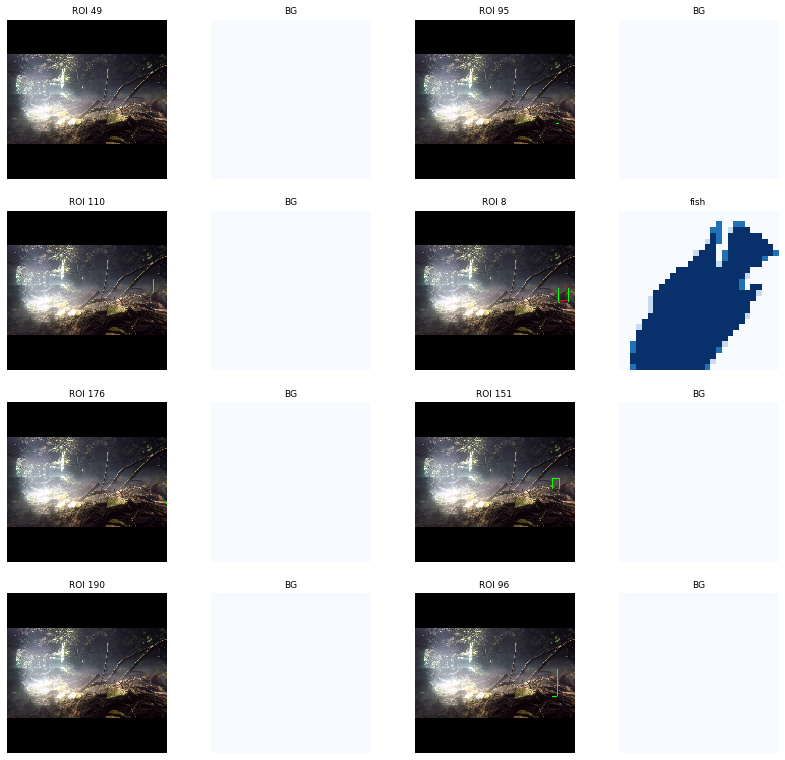

In [23]:
if random_rois:
    # Display ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]),8)
    
    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i]*255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])
        
    display_images(images,titles, cols = 4, cmap = "Blues", interpolation = "none")
    

In [24]:
# Check ratio of positive ROIs in a set of images
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, config, shuffle=True, random_rois = 10000,
        batch_size = 1, detection_targets = True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
Average percent: 0.33


# Try to extract instances

image_id:  269 /media/iimas-doc/Seagate Backup Plus Drive/Dataset_Thesis/Dia/Video_sin_reflejo/GOPR5104_7_5.jpg
original shape: (1080, 1920, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1024, 1024, 10)      min:    0.00000  max:    1.00000  bool
class_ids                shape: (10,)                 min:    1.00000  max:    1.00000  int32
bbox                     shape: (10, 4)               min:   27.00000  max: 1023.00000  int32


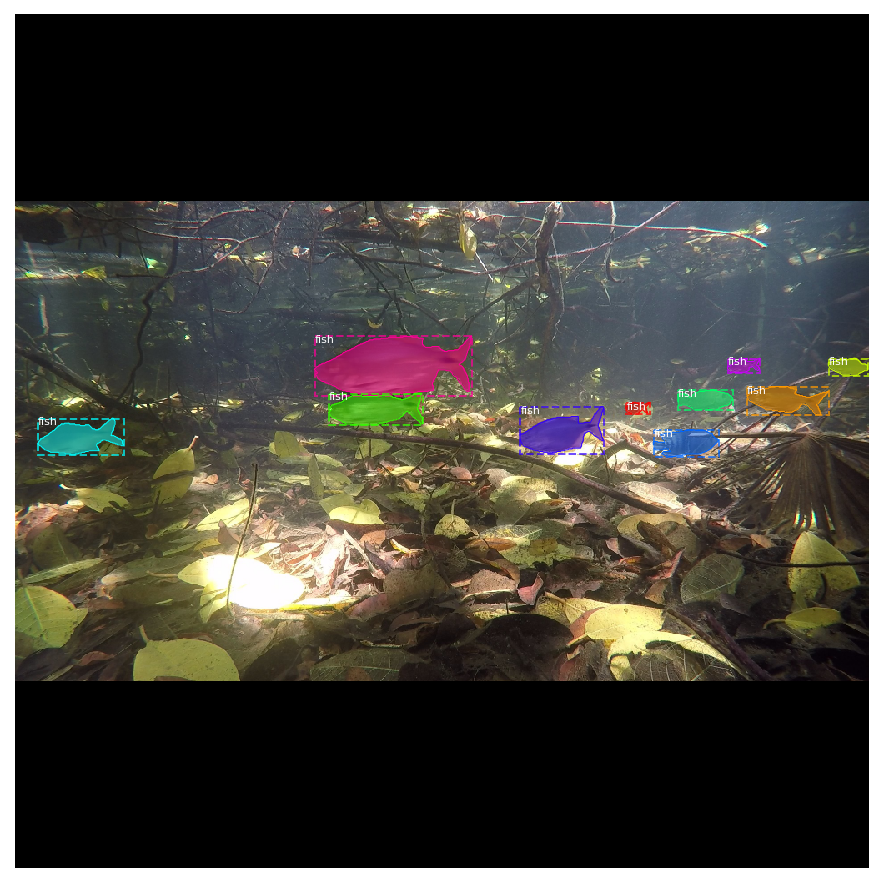

In [27]:
#Load random image and mask 
#image_id =np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
#Resize
image, window, scale, padding, _ =utils.resize_image(
    image,
    min_dim=config.IMAGE_MIN_DIM,
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

#Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("original shape:", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
#Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

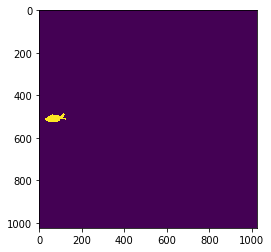

In [13]:
%matplotlib inline 
from matplotlib import pyplot as plt
plt.imshow(mask[:,:,0], interpolation='nearest')
plt.show()

In [28]:
instance_number=mask.shape[2]

In [29]:
bbox

array([[ 484,   27,  528,  130],
       [ 385,  359,  457,  548],
       [ 454,  376,  492,  489],
       [ 470,  606,  526,  706],
       [ 498,  766,  530,  844],
       [ 450,  795,  474,  861],
       [ 465,  733,  479,  762],
       [ 412,  855,  429,  894],
       [ 446,  878,  480,  976],
       [ 412,  976,  433, 1023]], dtype=int32)

In [66]:
new_images=[]
new_masks=[]
new_bbox=[]
for instance in range(instance_number):
    y1 = int(0.9*bbox[instance,0])
    x1 = int(0.9*bbox[instance,1])
    y2 = int(1.1*bbox[instance,2])
    x2 = int(1.1*bbox[instance,3])
    new_image=image[y1:y2,x1:x2]
    new_mask=mask[y1:y2,x1:x2,instance]
    new_mask = new_mask[:,:,np.newaxis]
    
    #Resize
    new2_image, window, scale, padding, _ =utils.resize_image(
    new_image,
    min_dim=config.IMAGE_MIN_DIM,
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
    new2_mask = utils.resize_mask(new_mask, scale, padding)
    # Compute Bounding box
    bbox2 = utils.extract_bboxes(new2_mask)
    
    new_images.append(new2_image)
    new_masks.append(new2_mask)
    new_bbox.append(bbox2)

In [150]:
new_images=[]
new_masks=[]
new_bbox=[]
for instance in range(instance_number):
    y1 = int(0.9*bbox[instance,0])
    x1 = int(0.9*bbox[instance,1])
    y2 = int(1.1*bbox[instance,2])
    x2 = int(1.1*bbox[instance,3])
    zoomed_image=image[y1:y2,x1:x2]
    zoomed_mask = mask[y1:y2,x1:x2]
    new_mask = np.array([[[]]])
    for i in range(instance_number):
        area = zoomed_mask[:,:,i].sum() #area in mask i
        if area < 100:
            pass
        else:
            new_mask = np.concatenate((new_mask,np.expand_dims(zoomed_mask[:,:,1],axis=2)), axis=2).shape 
    
    #Resize
    new2_image, window, scale, padding, _ =utils.resize_image(
    new_image,
    min_dim=config.IMAGE_MIN_DIM,
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
    new2_mask = utils.resize_mask(new_mask, scale, padding)
    # Compute Bounding box
    bbox2 = utils.extract_bboxes(new2_mask)
    
    new_images.append(new2_image)
    new_masks.append(new2_mask)
    new_bbox.append(bbox2)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [147]:
np.expand_dims(zoomed_mask[:,:,0],axis=2).shape

(145, 119, 1)

In [151]:
np.concatenate((np.array([[[]]]),np.expand_dims(zoomed_mask[:,:,1],axis=2)), axis=2).shape

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [158]:
np.concatenate((np.array([]),np.array([1,1])),axis=0)
np.array([[[]]]).shape

(1, 1, 0)

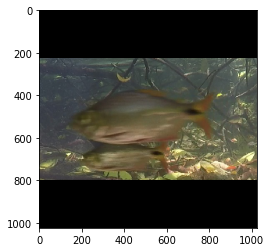

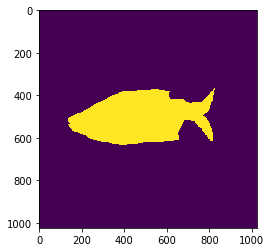

In [98]:
plt.imshow(new_images[1], interpolation='nearest')
plt.show()
plt.imshow(new_masks[1][:,:,1], interpolation='nearest')
plt.show()

In [55]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR) # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import fishvsall

%matplotlib inline

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")


In [56]:
# Override the training configurations with a few changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [57]:
# Device to load the neural network on.
# Useful if you're training a model on the same machine, 
#in which case use CPU and leave the GPU for training.
DEVICE = "/cpu:0" #/cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or ' training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = 'inference'

In [58]:
def get_ax(rows = 1, cols = 1, size = 16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a 
    central point to control graph sizes.
    
    Adjust the size attribute to control how big render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [59]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode = "inference", model_dir = MODEL_DIR, config = config)

W1107 14:24:04.072961 140258180679488 deprecation_wrapper.py:119] From /home/iimas-doc/anaconda3/envs/MaskRCNN/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1107 14:24:04.164525 140258180679488 deprecation_wrapper.py:119] From /home/iimas-doc/anaconda3/envs/MaskRCNN/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1107 14:24:04.212874 140258180679488 deprecation_wrapper.py:119] From /home/iimas-doc/anaconda3/envs/MaskRCNN/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1107 14:24:04.247144 140258180679488 deprecation_wrapper.py:119] From /home/iimas-doc/anaconda3/envs/MaskRCNN/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.f

In [60]:
# Set path to fish weights file

weights_path = "/media/iimas-doc/Seagate Backup Plus Drive/Tesis/Programas_Utiles/MaskRCNN/Mask_RCNN/logs/fish20191105T1139/mask_rcnn_fish_0060.h5"

# Or, load the last model you trained
# weights_path = model.find_last()

#Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name = True)

Loading weights  /media/iimas-doc/Seagate Backup Plus Drive/Tesis/Programas_Utiles/MaskRCNN/Mask_RCNN/logs/fish20191105T1139/mask_rcnn_fish_0060.h5
Re-starting from epoch 60


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


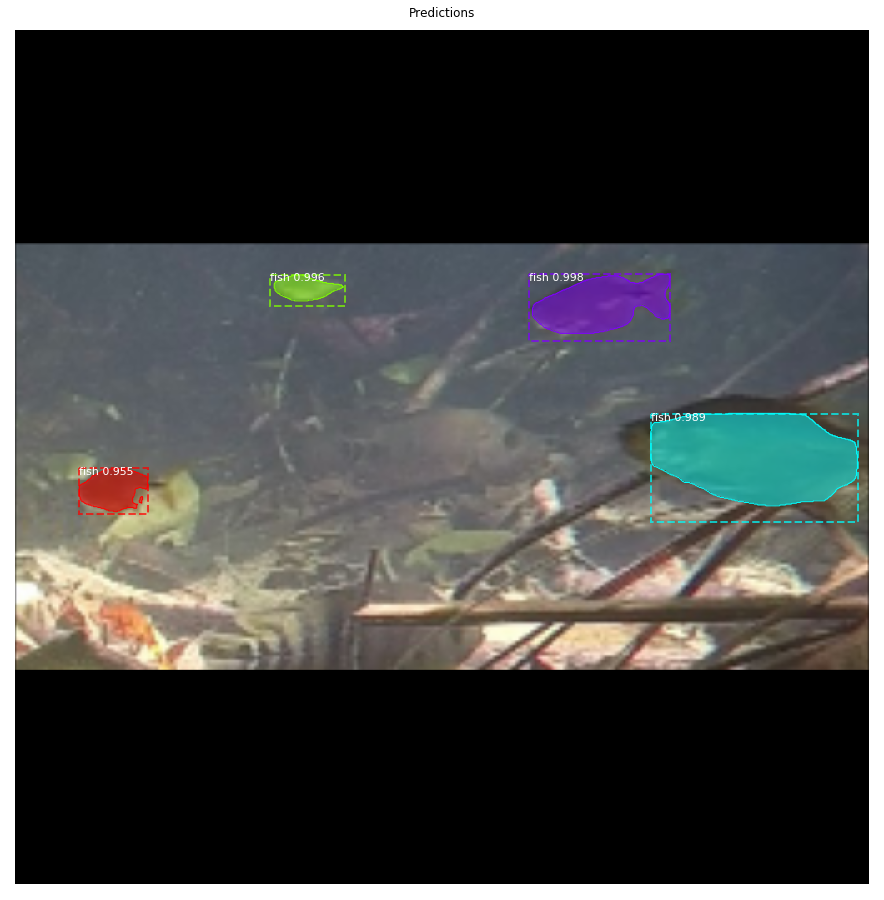

In [72]:
results= model.detect([new_images[5]], verbose = 1)
# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(new_images[5], r['rois'], r['masks'], r['class_ids'],
                           dataset.class_names, r['scores'], ax = ax,
                           title = "Predictions")
